# Timeseries correlation analysis and clustering

by Bart De Vylder and Pieter Buteneers from CoScale


## Intro

In this part we'll illustrate correlation analysis, clustering and dimensionality reduction based on a set of timeseries which are the CPU usages of some pysical nodes and the containers running on them. 

The analysis shown here was insipred by the sklearn application example for visualizing the stock market structure (http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html).

We start with importing all the necessary packages. 

In [116]:
import datetime

import pickle_helper
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, manifold, covariance

# Python 3 compatibility
from __future__ import print_function   # turns print into a function
from __future__ import division         # makes sure 3/2 = 1.5 and not 1 (use 3//2 = 1 instead)

## Importing and inspecting the data

We import the cpu usage of a production environment for some physical nodes and containers at 1 minute resolution for a time span of about 8 hours: 

In [117]:
nodes, ts_data = pickle_helper.load('data/correlation_series_cpu.pickle')

These are the names of the nodes, 
- host... are the physical machines
- cassandra... are the nodes of a cassandra cluster
- elasticsearch... are the nodes of an elasticsearch cluster
- dns... are the nodes of a dns service
- rumdatareceiver is a component which handles incoming rum (Real User Monitoring) data

In [118]:
for name in nodes:
    print(name)

elasticsearch004
host001
elasticsearch005
dns004
host012
cassandracl006
cassandracl002
host010
cassandracl007
dns001
elasticsearch009
elasticsearch008
host011
host008
host014
cassandracl003
elasticsearch006
host015
rumdatareceiver002
host006
host013
cassandracl008
host007
host009
cassandracl005
elasticsearch007
cassandracl011


We inspect the shape of the data: the 27 different timeseries are each in a row of the table:

In [119]:
ts_data.shape

(27, 501)

Let's reorder the nodes and timeseries so the node names are sorted alphabetically.

In [120]:
sort_idx = np.argsort(nodes)
nodes = nodes[sort_idx]
ts_data = ts_data[sort_idx]

Then we do a quick visual check whether the data makes sense:

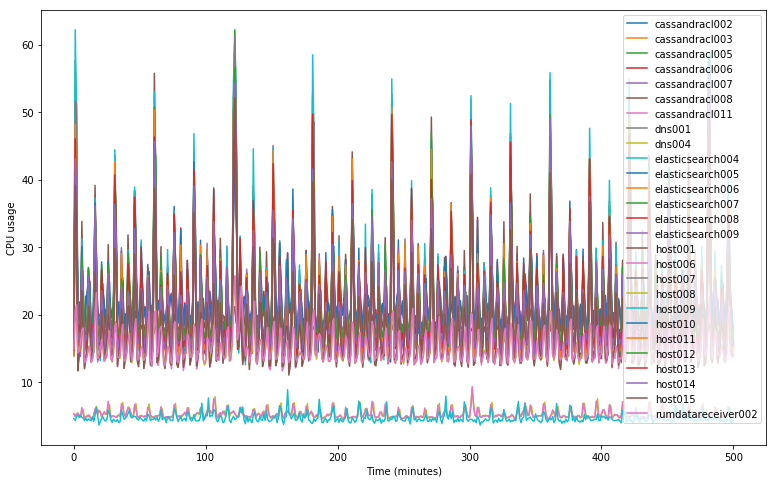

In [121]:
plt.figure(figsize=(13,8))
for node, timeseries in zip(nodes, ts_data):
    plt.plot(timeseries, label=node)
plt.legend(loc='upper right')

plt.xlabel("Time (minutes)")
plt.ylabel("CPU usage")
plt.show()

## Correlation analysis

Now we try to find some structure in this data: we're going to calculate the correlations between any two of these timeseries. The correlation between any two variables is a number between -1 and 1 which measures the degree at which deviations in one variable co-occur with deviations in another in the same direction. The correlation of a variable $V$ with itself is $1$, the correlation of a variable $V$ with its opposite $-V$ is $-1$. 


First, to understand what's going on, we'll calculate the empirical correlations between the timeseries directly. 

For that we first convert our dataset such that each timeseries has 0 mean and a standard deviation of 1. The standard deviation of numpy array can be calculated with  [np.std](http://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html) choosing the correct axis.

In [122]:
# First the data is copied and transposed so it fits the covariance estimator we'll used later on: now each timeseries is in 
# a column of the table (along axis=0). 
norm_ts_data = ts_data.copy().T

# Then we centralize the data and make sure it has a standard deviation of 1
### BEGIN SOLUTION
norm_ts_data -= np.mean(norm_ts_data, axis=0)
norm_ts_data /= np.std(norm_ts_data, axis=0)
### END SOLUTION

# subtract the mean of each timeseries
# norm_ts_data -= ...
# divide by the standard deviation
# norm_ts_data /= ...


# Some tests to see the result makes sense
rounding_error_allowed = 1e-10
assert norm_ts_data.shape == (501, 27)
assert np.all(np.abs(np.mean(norm_ts_data, axis=0)) < rounding_error_allowed)
assert np.all(np.abs(np.std(norm_ts_data, axis=0) - 1)  < rounding_error_allowed)

We now calculate the correlation matrix of our set of timeseries where 
$$ \text{Corr}_{i,j} = \text {correlation of } \text{ts}_i \text{and } \text{ts}_j $$

Because the data is already normalized, this boils down to calculating the dot-product two timeseries:
$$ \text{Corr}_{i,j} = \sum_{t} \text{ts}_i(t) \text{ts}_j(t) $$
    
which can be done in one matrix-multiplication using [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html).

In [123]:
### BEGIN SOLUTION
C_direct = np.dot(norm_ts_data.T, norm_ts_data)
### END SOLUTION
#C_direct = ...

assert C_direct.shape == (27, 27)

The resultin correlation matrix is a square, symmetrical matrix with values between -1 and 1. The values on the diagonal are 1 because each timeseries is maximally correlated with itself. We can visualize the correlations using matplotlib's [pcolor](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolor) method, which allows to visualize a matrix using color codes. Let's write a helper function for that

In [124]:
def plot_correlations(corr_mat, names):
    K = len(names)
    assert corr_mat.shape == (K, K)
    
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(corr_mat, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(K)+0.5, minor=False)
    ax.set_yticks(np.arange(K)+0.5, minor=False)

    # We want the diagonal to from topleft to bottomright
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(names, minor=False, rotation='vertical')
    ax.set_yticklabels(names, minor=False)
    ax.set_aspect(1)
    plt.show()

Now plot the correlations we calculated directly:

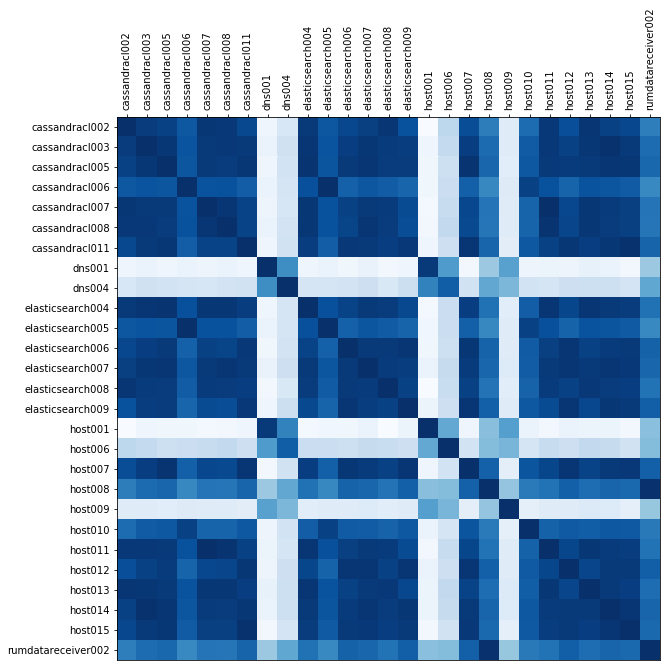

In [125]:
plot_correlations(C_direct, nodes)

We see the diagiagonal pattern clearly emerge. We also see very strong correlation between other timeseries. (Determining a correlation matrix this way using linear operations can also be done directly using the the built in numpy method [np.corrcoef](http://docs.scipy.org/doc/numpy/reference/generated/corrcoef.std.html)).  

Now, we'll use a more advanced technique to determine correlations called [graph lasso](http://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphLassoCV.html) which is less likely to overestimate the correlations by assigning a penalty to them and doing cross-validation. We also feed it the normalized data because that's more suiteable to recover the structure of the data. 

In [126]:
graph_lasso_model = covariance.GraphLassoCV()
graph_lasso_model.fit(norm_ts_data)
C_lasso = graph_lasso_model.covariance_

/home/bart/anaconda3/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.361e-04
  ConvergenceWarning)


Inspecting the resulting correlation matrix shows it is more modest in it's estimation of the correlations:

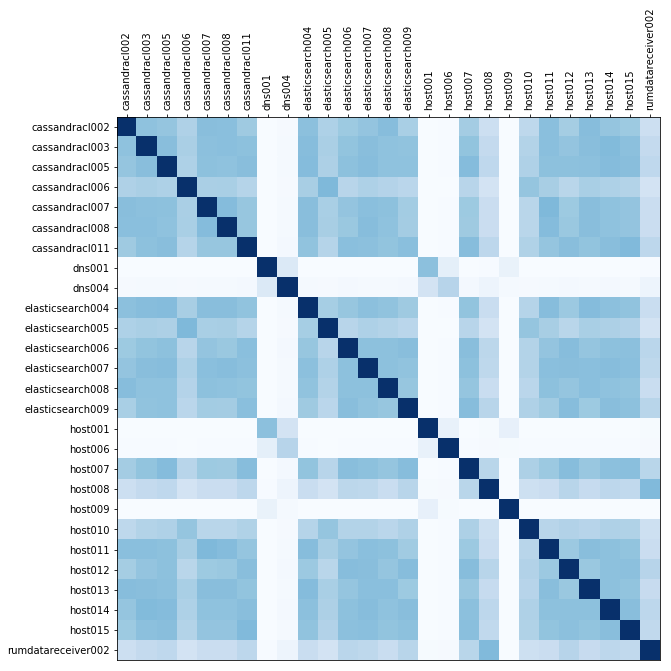

In [127]:
plot_correlations(C_lasso, nodes)

## Clustering

Now, based on the correlation coefficients, we try to cluster the timeseries. For this we use a technique called [affinity propagation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.affinity_propagation.html). It is an iterative technique which sends messages between the items to classify. One advantage of affinity propagation is that it does not require us to specify the nymber of clusters beforehand.


In [128]:
cluster_centers, labels = cluster.affinity_propagation(C_lasso)
print(cluster_centers)
print(labels)

num_clusters = max(labels) + 1

[ 3  8 12 15 16 19]
[2 2 2 0 2 2 2 3 1 2 0 2 2 2 2 3 4 2 2 5 0 2 2 2 2 2 2]


The cluster_centers are the most prototypical datapoints it found for each cluster. If all went well there are 6 clusters found, the labels define in which cluster each datapoint lies.

Now let's take a closer look to the clusters found:

In [129]:
clusters = {c : [] for c in range(num_clusters)}

for i, label in enumerate(labels):
    clusters[label].append(nodes[i])

for c, v in clusters.items():
    print(c, v)

0 ['cassandracl006', 'elasticsearch005', 'host010']
1 ['dns004']
2 ['cassandracl002', 'cassandracl003', 'cassandracl005', 'cassandracl007', 'cassandracl008', 'cassandracl011', 'elasticsearch004', 'elasticsearch006', 'elasticsearch007', 'elasticsearch008', 'elasticsearch009', 'host007', 'host008', 'host011', 'host012', 'host013', 'host014', 'host015', 'rumdatareceiver002']
3 ['dns001', 'host001']
4 ['host006']
5 ['host009']


If we compare this with the real layout of the containers on the physical nodes, we see that the structure is partially uncovered. Most of the hosts serving cassanddra and elasticsearch have be put into the same cluster because their load is very alike.  

#### Real node layout
- host001
    - dns001
- host006
    - dns004
- host007
    - cassandracl005
    - elasticsearch004
- host008
    - rumdatareceiver002
- host009
- host010
    - cassandracl006
    - elasticsearch005
- host011
    - cassandracl007
    - elasticsearch006
- host012
    - cassandracl008
    - elasticsearch007
- host013
    - cassandracl002
    - elasticsearch013
- host014
    - cassandracl003
    - elasticsearch009
- host015
    - cassandracl011

## Dimensionality reduction / visualization

Finally we going to try plotting the clusters by using dimensionality reduction. To start, we have data in a 27-dimensional space: if we want to represent a point in time for our data, we need to specify 27 numbers, because we have 27 timeseries. We have also see, however, that much of the data is strongly correlated, so we have an opportunity to reduce the dimensions of the data, to compress it, without throwing away too much information. 

In the current case, as we want to visualize our different timeseries in a 2-dimensional plane, we going to only retain 2 dimensions. 

A well known technique for dimensionality reduction is called Principle Component Analysis (PCA), which finds a linear transformation of the data to a new coordinate system in such that the new components (dimensions) have no correlation with each other and in which the variance of each successive component is maximized. To reduce the data to 2 dimension, it then suffices to only keep the first two components/dimensions.

The technique we'll use here is called [local linear embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html). It is based on PCA but allows different linear transformations in different areas of the input space, thereby avoiding overfitting. Original code : (http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html) 


In [130]:
# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(norm_ts_data.T).T

embedding.shape

(2, 27)

The embedding now contains the coordinates of the nodes to plot in the plane. The following code also makes use of the clusters found to color the nodes, and uses the correlations to draw lines between the nodes with an intensity related to the correlation. 

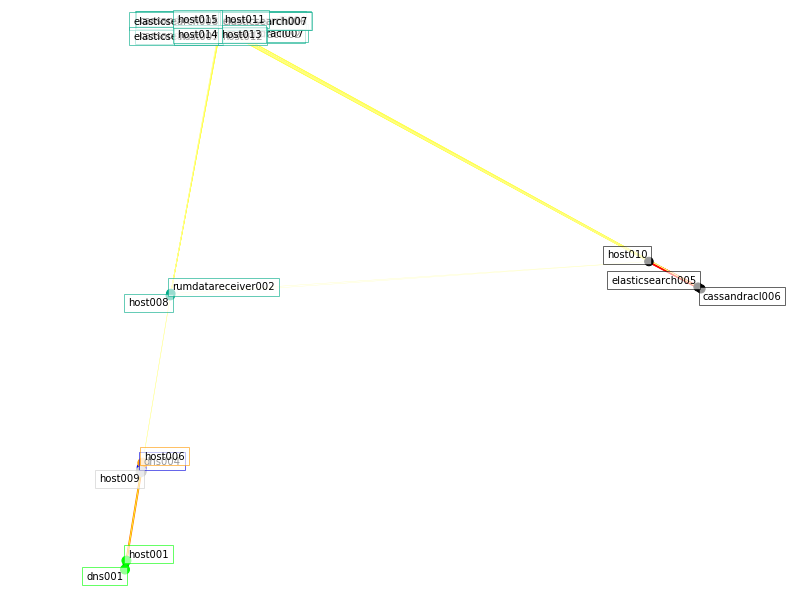

In [131]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = m.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (node, label, (x, y)) in enumerate(
        zip(nodes, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, node, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

While the clustering information was not use to determine the 2-dimensional positioning of the points, it is clear that both techniques (clustering versus dimensionality reduction) decide on a similar proximity of the nodes.  